In [3]:
# Specify CUDA device
import os
os.environ['CUDA_VISIBLE_DEVICES'] = 'gpu'

from jax import jit, config, grad
config.update("jax_enable_x64", True)


# Check we're running on GPU
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

import numpy as np
import jax.numpy as jnp
import optax

from matplotlib import pyplot as plt
from importlib import reload

import scatcovjax.Sphere_lib as sphlib
import scatcovjax.Synthesis_lib as synlib
from scatcovjax.Scattering_lib import scat_cov_axi, scat_cov_dir
from s2wav.filter_factory.filters import filters_directional_vectorised

import s2fft
import s2wav

import scatcovjax.plotting as plot
plot.notebook_plot_format()

cpu


In [4]:
s2fft.inverse_jax

<PjitFunction of <function inverse_jax at 0x7fc11a67de50>>

# Parameters

In [5]:
sampling = "mw"
multiresolution = True
reality = True

L = 16
N = 1
J_min = 0

J = s2wav.utils.shapes.j_max(L)
print(f'{J=}')

axi = True if N == 1 else False  # Axisym or directional
print(f'{axi=}')

J=4
axi=True


# Target map

In [6]:
reload(sphlib)
f_target, flm_target = sphlib.make_MW_planet(L, 'venus', normalize=True, reality=reality)


(16, 31)


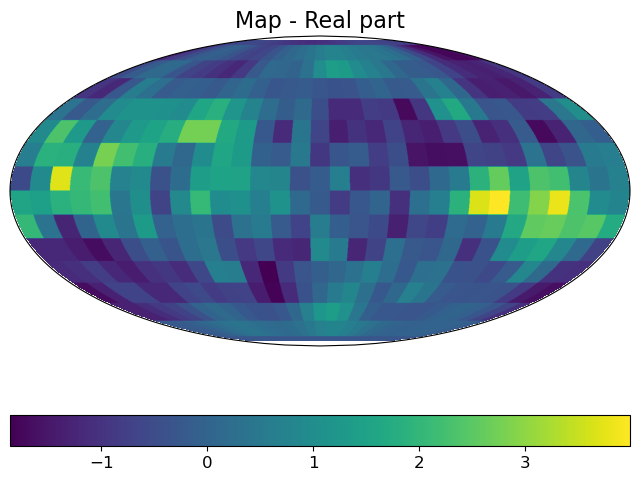

In [7]:
# Plot the map
mx, mn = np.nanmax(f_target), np.nanmin(f_target)
plot.plot_map_MW_Mollweide(f_target, figsize=(8, 6), vmin=mn, vmax=mx)

# Wavelets

(5, 16, 31)


(<Figure size 800x600 with 1 Axes>, <Axes: >)

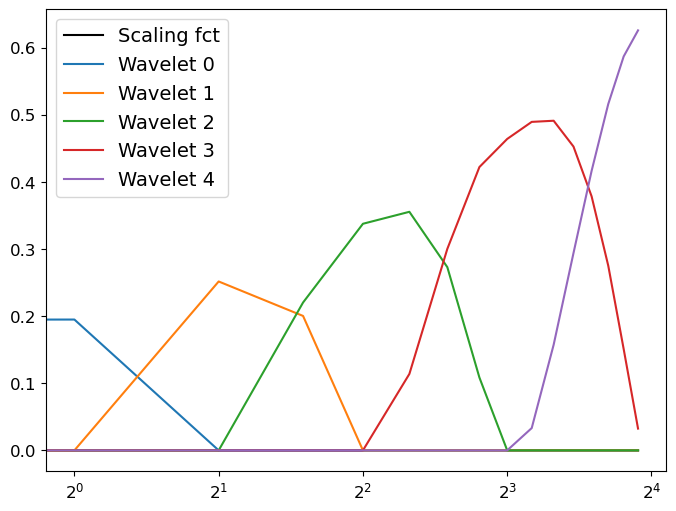

In [8]:
filters = filters_directional_vectorised(L, N, J_min)
print(filters[0].shape)

plot.plot_filters(filters, real=True, m=L-1)

# Compute the coeff of the target

In [9]:
tcoeffs = scat_cov_axi(flm_target, L, N, J_min, sampling, None,
                                                reality, multiresolution, filters=filters)

In [11]:
tcoeffs
tmean, tvar, tS1, tP00, tC01, tC11 = tcoeffs
tmean

Array(0.16798435, dtype=float64)

In [6]:
if axi:
    tmean, tvar, tS1, tP00, tC01, tC11 = scat_cov_axi(flm_target, L, N, J_min, sampling, None,
                                                reality, multiresolution, filters=filters)
else:
    tmean, tvar, tS1, tP00, tC01, tC11 = scat_cov_dir(flm_target, L, N, J_min, sampling, None,
                                                reality, multiresolution, filters=filters)
print(tmean, tC01)

0.1679843489758076 [ 4.01034210e-04+0.00000000e+00j  9.11456311e-05+0.00000000e+00j
 -1.67058730e-05-1.76970102e-23j  9.47751967e-05+0.00000000e+00j
  6.21534735e-04+5.74635929e-21j -3.13137422e-05-4.70702328e-21j
  4.26436314e-05+0.00000000e+00j  2.15642812e-04+1.17779838e-22j
  6.76571154e-06+5.92817446e-22j  2.17268075e-05+3.64350824e-22j]


# Initial condition

In [7]:
f = np.random.randn(L, 2*L-1).astype(np.float64)
flm = s2fft.forward_jax(f, L, reality=reality)
flm = flm[:,L-1:] if reality else flm

flm_start = jnp.copy(flm)

# Define the loss

In [8]:
def loss_func(flm):
    if axi:
        mean_new, var_new, S1_new, P00_new, C01_new, C11_new = scat_cov_axi(flm, L, N, J_min, sampling, 
                                                                            None, reality, multiresolution, 
                                                                            normalisation=None, filters=filters)
    else:
        mean_new, var_new, S1_new, P00_new, C01_new, C11_new = scat_cov_dir(flm, L, N, J_min, sampling, 
                                                                            None, reality, multiresolution, 
                                                                            normalisation=None, filters=filters)
    # Control for mean + var
    loss = synlib.chi2(tmean, mean_new)
    loss += synlib.chi2(tvar, var_new)
    
    # Add S1, P00, C01, C11 losses
    loss += synlib.chi2(tS1, S1_new)
    loss += synlib.chi2(tP00, P00_new)
    loss += synlib.chi2(tC01, C01_new)
    loss += synlib.chi2(tC11, C11_new)
    
    return loss


# Run the synthesis

In [9]:
# Naive implementation
flm, loss_history = synlib.fit_brutal(flm, loss_func, momentum=2., niter=10)

Iter 0: Loss = 0.05457, Momentum = 2.0, Time = 39.34 s/iter
Iter 1: Loss = 0.04202, Momentum = 2.0, Time = 0.10 s/iter
Iter 2: Loss = 0.03376, Momentum = 2.0, Time = 0.09 s/iter
Iter 3: Loss = 0.02783, Momentum = 2.0, Time = 0.09 s/iter
Iter 4: Loss = 0.02330, Momentum = 2.0, Time = 0.09 s/iter
Iter 5: Loss = 0.01968, Momentum = 2.0, Time = 0.09 s/iter
Iter 6: Loss = 0.01669, Momentum = 2.0, Time = 0.09 s/iter
Iter 7: Loss = 0.01419, Momentum = 2.0, Time = 0.09 s/iter
Iter 8: Loss = 0.01208, Momentum = 2.0, Time = 0.09 s/iter
Iter 9: Loss = 0.01030, Momentum = 2.0, Time = 0.09 s/iter


In [10]:
# Using Optax
# optimizer = optax.adagrad(learning_rate=1.)
optimizer = optax.sgd(learning_rate=1.)
flm, loss_history = synlib.fit_optax(flm, optimizer, loss_func, niter=12)

Iter 0, Loss: 0.01030, Time = 32.33669 s/iter
Iter 1, Loss: 0.01056, Time = 0.00366 s/iter
Iter 2, Loss: 0.01084, Time = 0.00357 s/iter
Iter 3, Loss: 0.01112, Time = 0.00359 s/iter
Iter 4, Loss: 0.01142, Time = 0.00357 s/iter
Iter 5, Loss: 0.01173, Time = 0.00356 s/iter
Iter 6, Loss: 0.01205, Time = 0.00357 s/iter
Iter 7, Loss: 0.01237, Time = 0.00354 s/iter
Iter 8, Loss: 0.01271, Time = 0.00355 s/iter
Iter 9, Loss: 0.01305, Time = 0.00354 s/iter
Iter 10, Loss: 0.01341, Time = 0.00355 s/iter
Iter 11, Loss: 0.01378, Time = 0.00355 s/iter


# Check the synthesis

In [ ]:
reload(sphlib)
if reality:
    flm_full_target = sphlib.make_flm_full(flm_target, L)
    flm_full_start = sphlib.make_flm_full(flm_start, L)
    flm_full_end = sphlib.make_flm_full(flm, L)
else:
    flm_full_target = flm_target
    flm_full_start = flm_start
    flm_full_end = flm

f_target = s2fft.inverse_jax(flm_full_target, L, reality=reality)
f_start = s2fft.inverse_jax(flm_full_start, L, reality=reality)
f_end = s2fft.inverse_jax(flm_full_end, L, reality=reality)

### Plot the loss

Text(0.5, 0, 'Number of iterations')

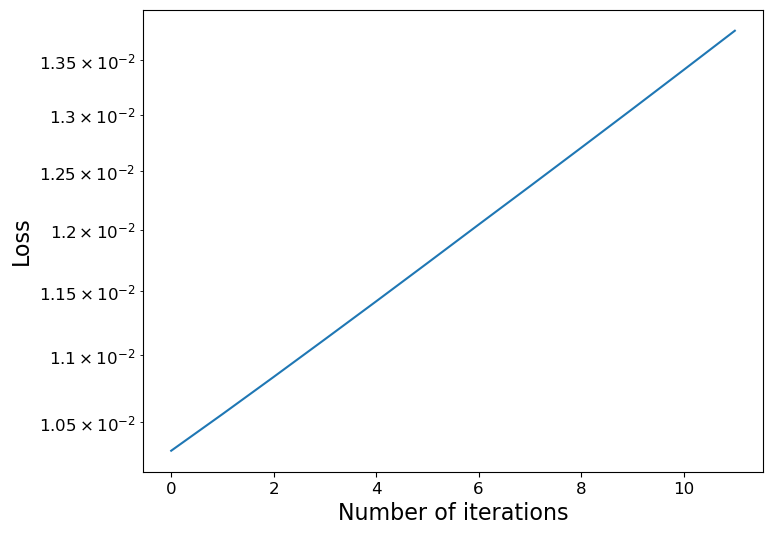

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(loss_history)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of iterations')

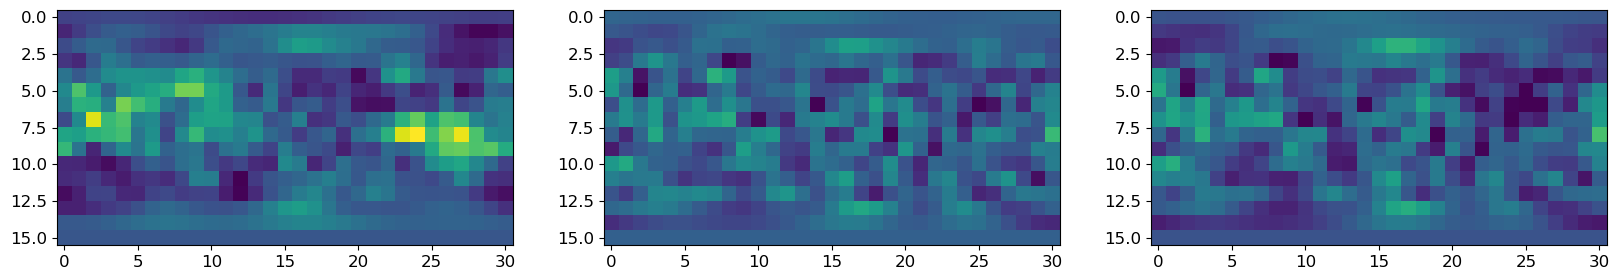

In [12]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(f_target, vmax=mx, vmin=mn, cmap='viridis')
ax2.imshow(f_start, vmax=mx, vmin=mn, cmap='viridis')
ax3.imshow(f_end, vmax=mx, vmin=mn, cmap='viridis')
plt.show()

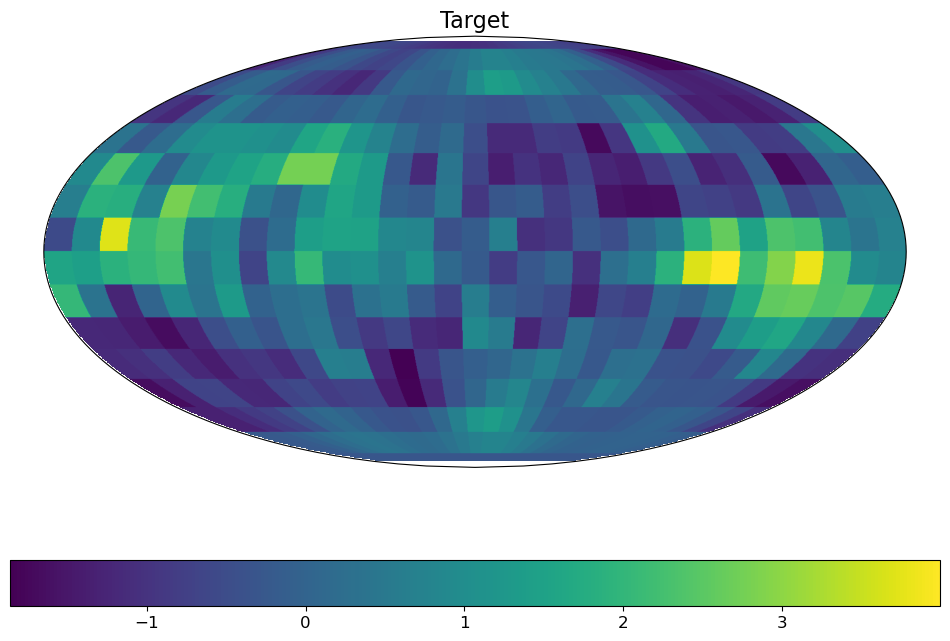

In [13]:
plot.plot_map_MW_Mollweide(f_target, vmin=mn, vmax=mx, title='Target')

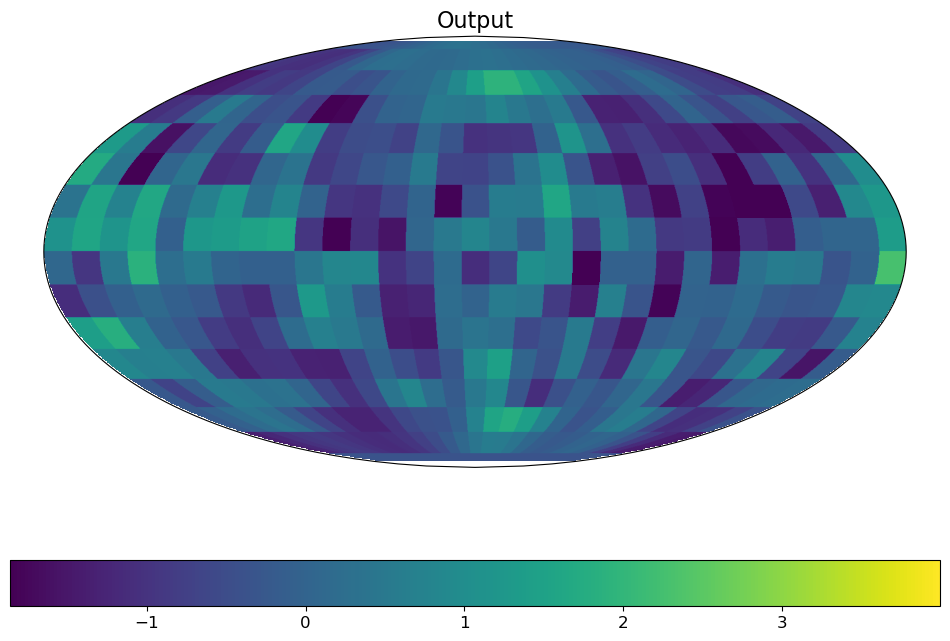

In [14]:

plot.plot_map_MW_Mollweide(f_end, vmin=mn, vmax=mx, title='Output', central_longitude=0)

### Power spectrum

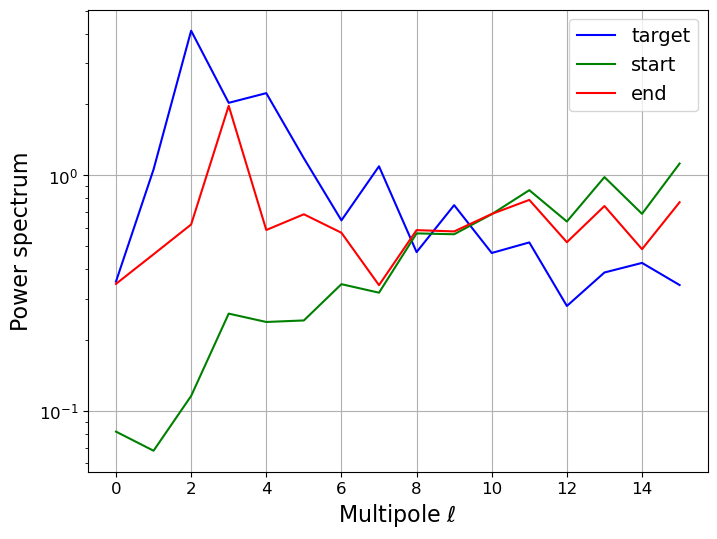

In [42]:
reload(sphlib)
ps_target = sphlib.compute_ps(flm_full_target)
ps_start = sphlib.compute_ps(flm_full_start)
ps_end = sphlib.compute_ps(flm_full_end)

plt.figure(figsize=(8, 6))
plt.plot(ps_target, 'b', label="target")
plt.plot(ps_start, 'g', label="start")
plt.plot(ps_end, 'r', label="end")
plt.yscale("log")
plt.xlabel(r'Multipole $\ell$')
plt.ylabel('Power spectrum')
plt.grid()
plt.legend()

### Plot the coefficients

In [38]:
tmean, tvar, tS1, tP00, tC01, tC11 = scat_cov_axi(flm_full_target, L, N, J_min, sampling, None,
                                                  reality=False,
                                                  multiresolution=multiresolution,
                                                  filters=filters)
smean, svar, sS1, sP00, sC01, sC11 = scat_cov_axi(flm_full_start, L, N, J_min, sampling, None,
                                                  reality=False,
                                                  multiresolution=multiresolution,
                                                  filters=filters)
emean, evar, eS1, eP00, eC01, eC11 = scat_cov_axi(flm_full_end, L, N, J_min, sampling, None,
                                                  reality=False,
                                                  multiresolution=multiresolution,
                                                  filters=filters)

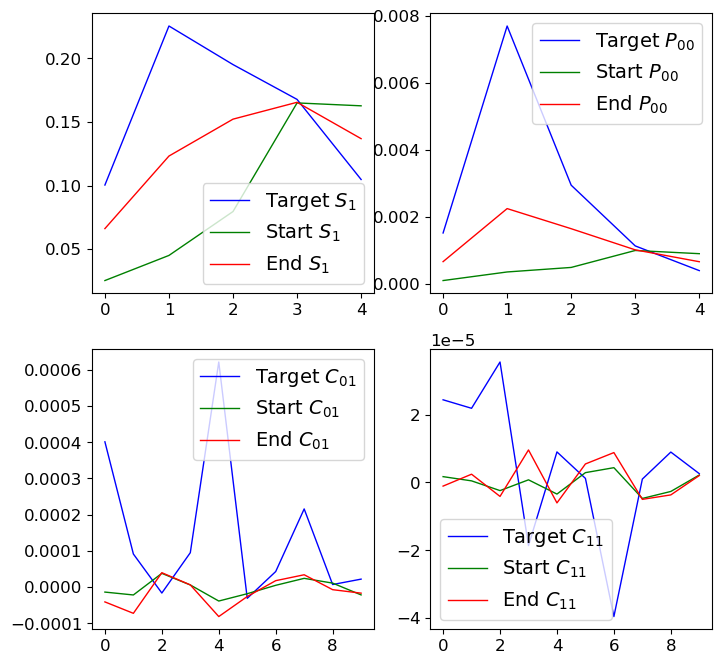

In [51]:
reload(plot)
plot.plot_scatcov_coeffs(tS1, tP00, tC01, tC11, name='Target', hold=True, color='blue', lw=1)

plot.plot_scatcov_coeffs(sS1, sP00, sC01, sC11, name='Start', hold=False, color='green', lw=1)

plot.plot_scatcov_coeffs(eS1, eP00, eC01, eC11, name='End', hold=False, color='red', lw=1)